# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

For this script to run, following files of the data script must have been generated and present in the folder containing this script which are:

- 'DataFrame'
- 'clean_data'
- 'adjacency_matrix.csv'
- 'test.csv'

In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load and Inspect the Data

Below a general overview of the dataset is gained.

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
# Adjust coding of Class, such that range is from 1-3. Was 0-2 before for the MAG generation process
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,0,69,0,1,964,3,2,3,3,...,2,5,5,3,5,1,5,3,0,0
1,0,0,55,1,3,240,2,5,5,5,...,2,1,1,2,3,2,3,2,163,0
2,1,0,51,1,3,2672,5,5,5,5,...,1,4,4,4,4,5,4,3,0,1
3,0,1,27,1,1,495,2,3,2,2,...,3,3,4,4,3,4,2,3,0,0
4,0,0,12,0,1,462,2,4,2,3,...,2,2,3,4,2,2,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,49,0,1,1587,3,4,3,4,...,5,4,4,3,5,3,4,5,35,0
5996,1,0,33,0,1,588,2,5,2,3,...,5,5,5,3,5,5,5,5,0,0
5997,0,0,50,0,1,2358,1,4,1,5,...,4,4,4,5,4,4,3,4,0,0
5998,0,0,35,0,1,672,2,3,2,2,...,5,5,1,1,4,4,1,5,0,0


In [7]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

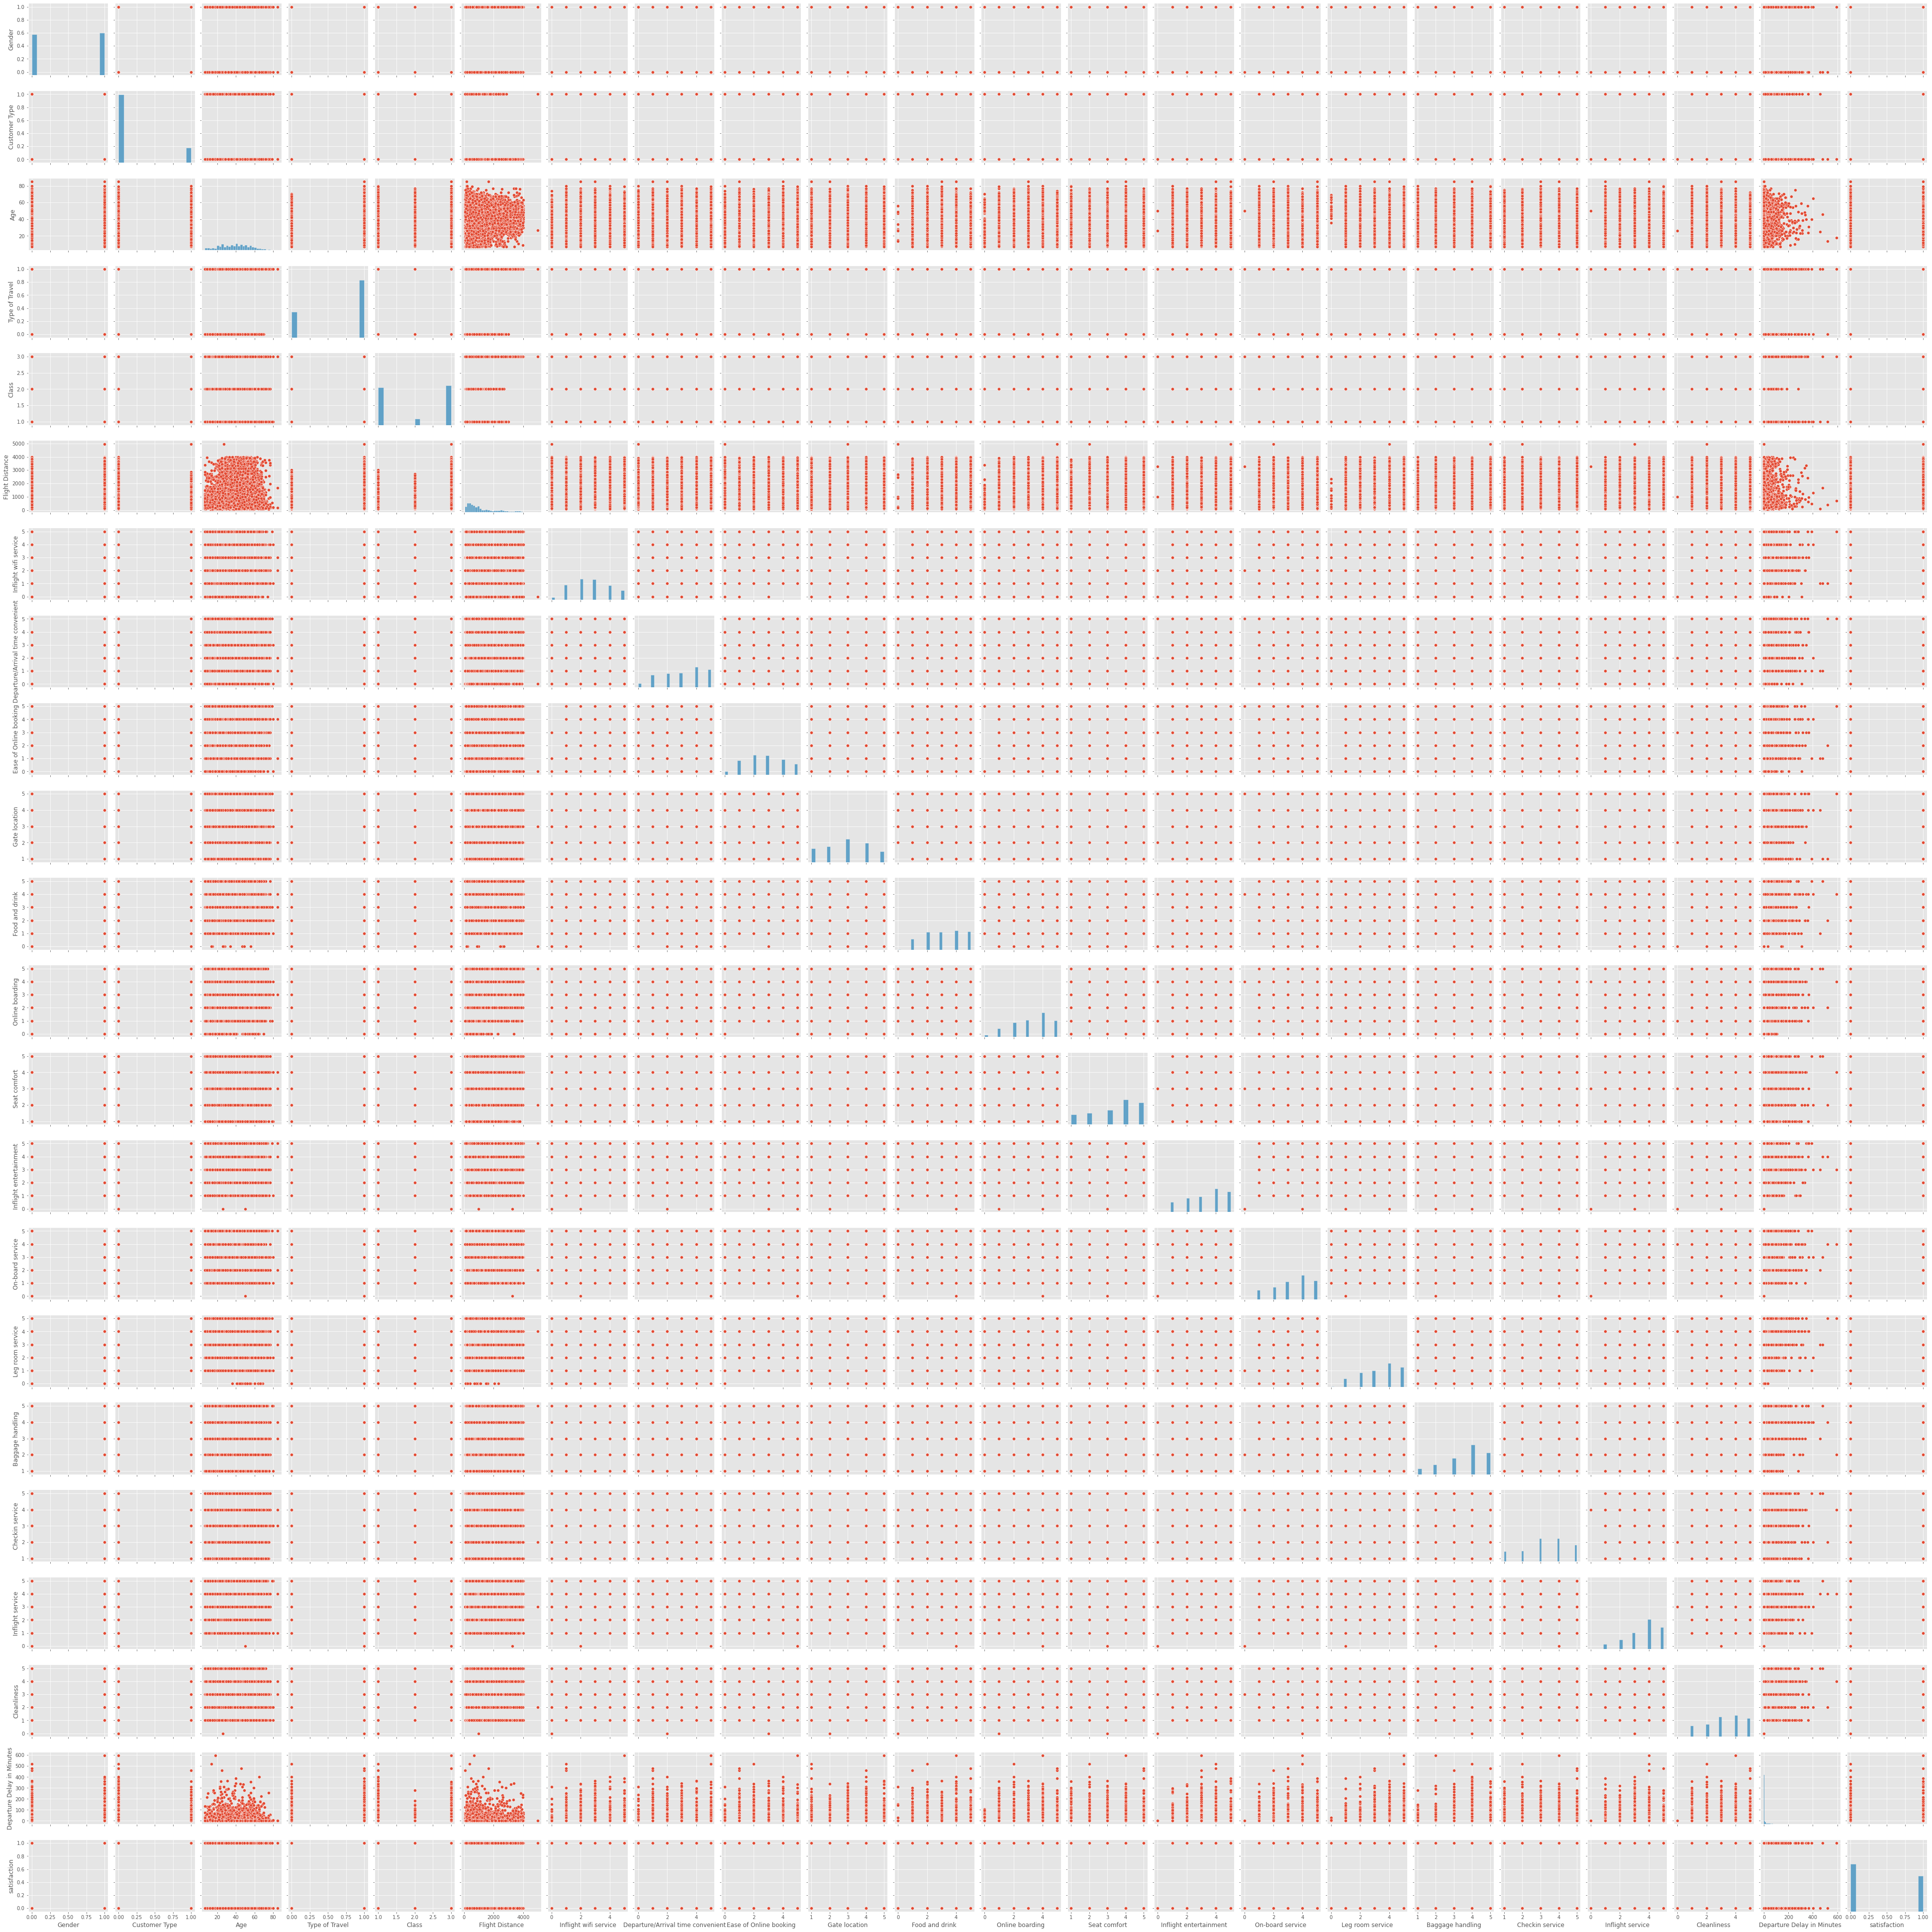

In [8]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [9]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [10]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [11]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [12]:
np.diag(A).sum()

0.0

In [13]:
G = nx.from_numpy_matrix(A)

In [14]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [15]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [16]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [17]:
TEST = df_test.copy(deep=True)

In [18]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [19]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [20]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [21]:
pos = nx.spring_layout(G)

In [22]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

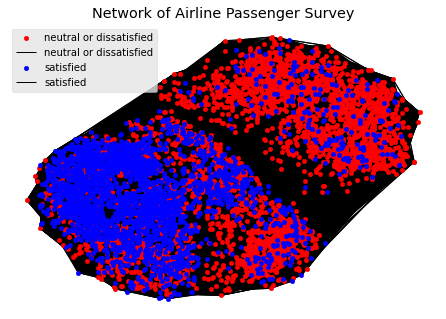

In [23]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

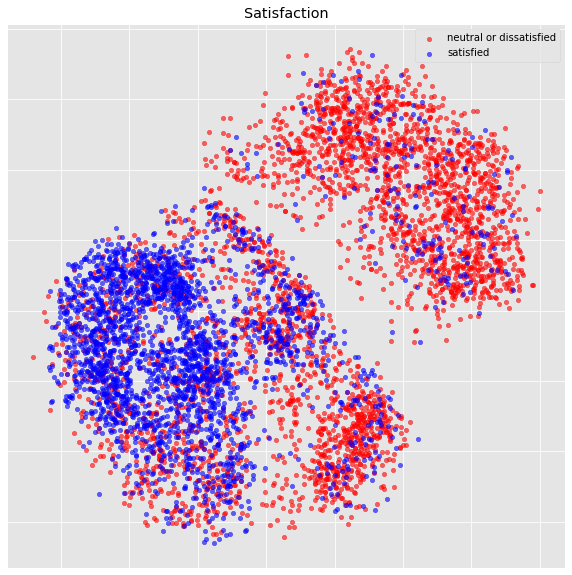

In [24]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

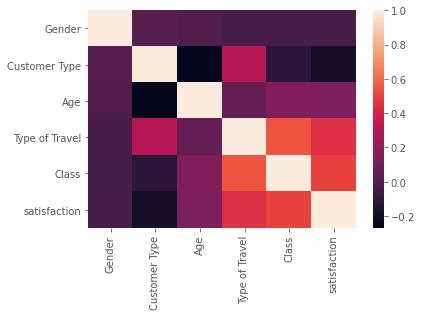

In [25]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [26]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

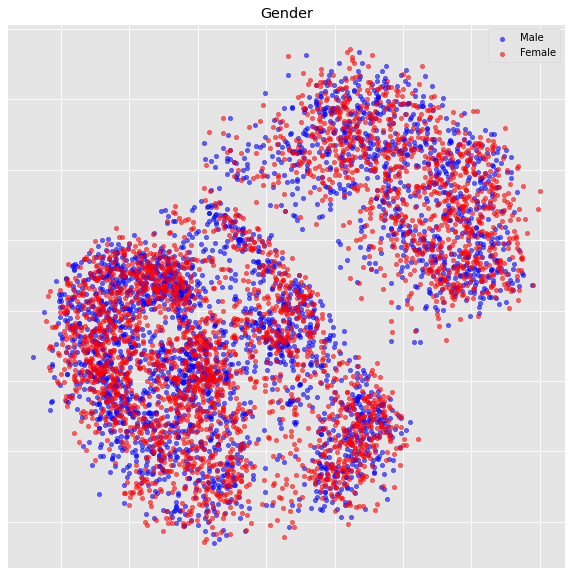

In [27]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [28]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

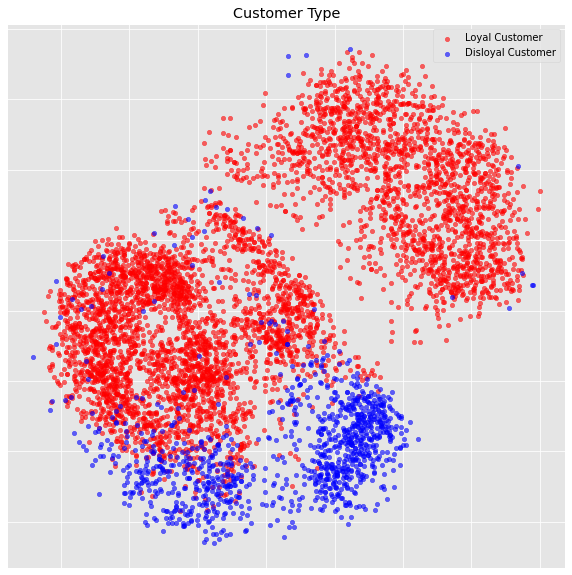

In [29]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [30]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

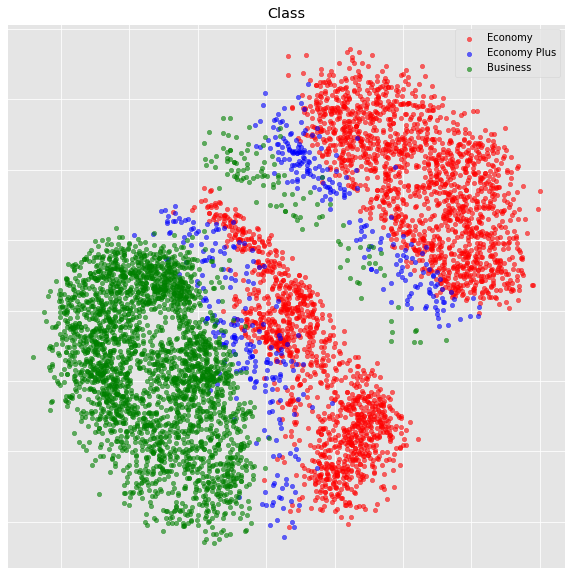

In [31]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [32]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

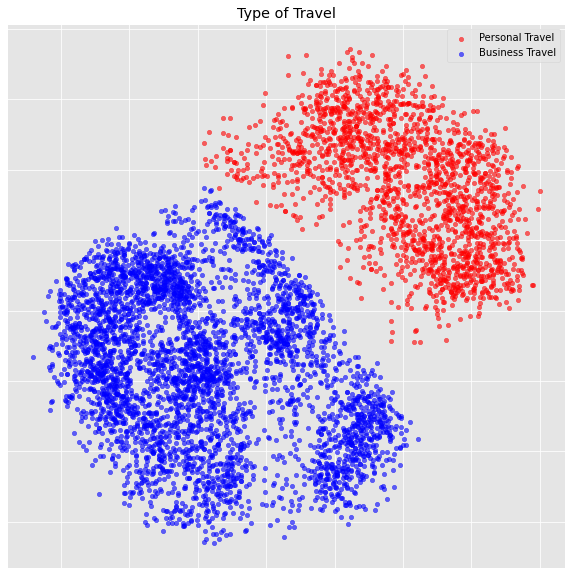

In [33]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [34]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [35]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

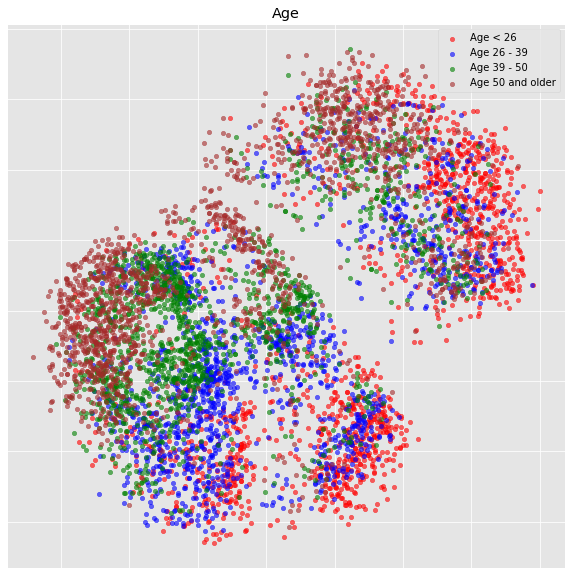

In [36]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

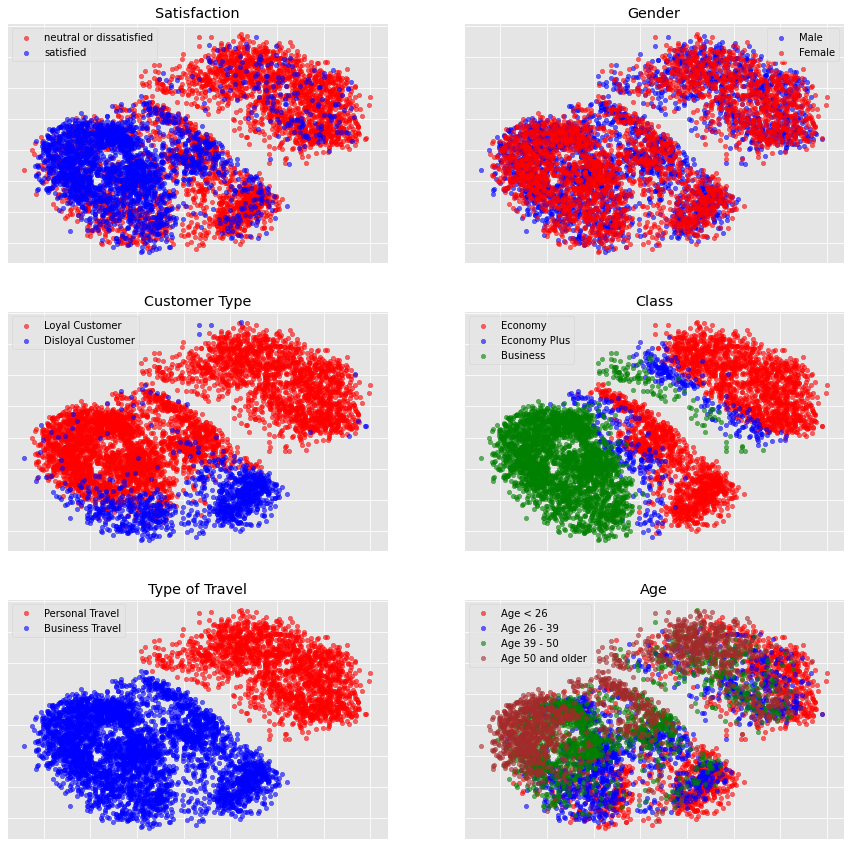

In [37]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [38]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [39]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [40]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [41]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [42]:
len(train_nids)

4862

In [43]:
len(valid_nids)

1138

## Define the Dataloaders

In [44]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [45]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([1965, 5001, 2561,  ..., 4547, 4185, 2366]), tensor([1965, 5001, 2561, 3911, 2992, 2103, 1467, 5508, 4951, 5224, 5051, 4696,
        4207, 5166, 5740, 1900, 5046, 2661, 5833, 4618, 4712, 1961, 3699, 5406,
        3778, 4039, 1073, 2203, 1814, 2818, 3851, 1484,  630, 2949,  460,  306,
        5237,  778, 3024, 4122, 2901, 5074, 5090,  621, 1217, 2040, 1074, 2477,
        2279, 4515]), [Block(num_src_nodes=2477, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]]


In [46]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2477 nodes' input features


In [47]:
print(bipartites)

[Block(num_src_nodes=2477, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]


In [48]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [49]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [50]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [51]:
# choose between sumSage or the standard GraphSage models and define the optimizer

#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [52]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.642, Training Loss: 0.633
Epoch: 0, Validation Accuracy: 0.774, Validation Loss: 0.528, Time: 2.0162
Epoch: 1, Training Accuracy: 0.814, Training Loss: 0.455
Epoch: 1, Validation Accuracy: 0.840, Validation Loss: 0.404, Time: 1.6429
Epoch: 2, Training Accuracy: 0.843, Training Loss: 0.397
Epoch: 2, Validation Accuracy: 0.847, Validation Loss: 0.370, Time: 1.5652
Epoch: 3, Training Accuracy: 0.852, Training Loss: 0.376
Epoch: 3, Validation Accuracy: 0.860, Validation Loss: 0.352, Time: 1.5226
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.368
Epoch: 4, Validation Accuracy: 0.864, Validation Loss: 0.339, Time: 1.5087
Epoch: 5, Training Accuracy: 0.862, Training Loss: 0.346
Epoch: 5, Validation Accuracy: 0.866, Validation Loss: 0.340, Time: 1.5020
Epoch: 6, Training Accuracy: 0.869, Training Loss: 0.337
Epoch: 6, Validation Accuracy: 0.867, Validation Loss: 0.328, Time: 1.5189
Epoch: 7, Training Accuracy: 0.863, Training Loss: 0.336
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 62, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.3457
Epoch: 63, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 63, Validation Accuracy: 0.936, Validation Loss: 0.173, Time: 1.3429
Epoch: 64, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 64, Validation Accuracy: 0.924, Validation Loss: 0.186, Time: 1.3405
Epoch: 65, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 65, Validation Accuracy: 0.935, Validation Loss: 0.165, Time: 1.3396
Epoch: 66, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 66, Validation Accuracy: 0.936, Validation Loss: 0.162, Time: 1.3399
Epoch: 67, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 67, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.3372
Epoch: 68, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 68, Validation Accuracy: 0.941, Validation Loss: 0.155, Time: 1.3356
Epoch: 69, Training Accuracy: 0.941, Training Loss: 0.153
Epoc

Epoch: 123, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 123, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.3047
Epoch: 124, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 124, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.3028
Epoch: 125, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 125, Validation Accuracy: 0.938, Validation Loss: 0.146, Time: 1.3010
Epoch: 126, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 126, Validation Accuracy: 0.942, Validation Loss: 0.151, Time: 1.2992
Epoch: 127, Training Accuracy: 0.949, Training Loss: 0.138
Epoch: 127, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.2975
Epoch: 128, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 128, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.2965
Epoch: 129, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 129, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 1.2956
Epoch: 130, Training Accuracy: 0.942, Training L

Epoch: 184, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 184, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.3083
Epoch: 185, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 185, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.3096
Epoch: 186, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 186, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.3123
Epoch: 187, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 187, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.3158
Epoch: 188, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 188, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.3179
Epoch: 189, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.3178
Epoch: 190, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 190, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.3167
Epoch: 191, Training Accuracy: 0.954, Training L

Epoch: 245, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 245, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.3251
Epoch: 246, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 246, Validation Accuracy: 0.938, Validation Loss: 0.155, Time: 1.3247
Epoch: 247, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 247, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.3268
Epoch: 248, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 248, Validation Accuracy: 0.940, Validation Loss: 0.163, Time: 1.3261
Epoch: 249, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 249, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.3256
Epoch: 250, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 250, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.3250
Epoch: 251, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 251, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.3252
Epoch: 252, Training Accuracy: 0.953, Training L

Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 306, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 1.3090
Epoch: 307, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.3089
Epoch: 308, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 308, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.3086
Epoch: 309, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 309, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.3082
Epoch: 310, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 310, Validation Accuracy: 0.941, Validation Loss: 0.137, Time: 1.3079
Epoch: 311, Training Accuracy: 0.953, Training Loss: 0.116
Epoch: 311, Validation Accuracy: 0.938, Validation Loss: 0.166, Time: 1.3077
Epoch: 312, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 312, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.3076
Epoch: 313, Training Accuracy: 0.953, Training L

Epoch: 367, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 367, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.2943
Epoch: 368, Training Accuracy: 0.954, Training Loss: 0.115
Epoch: 368, Validation Accuracy: 0.946, Validation Loss: 0.153, Time: 1.2941
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.2937
Epoch: 370, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.154, Time: 1.2934
Epoch: 371, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 371, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.2933
Epoch: 372, Training Accuracy: 0.956, Training Loss: 0.112
Epoch: 372, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.2931
Epoch: 373, Training Accuracy: 0.956, Training Loss: 0.114
Epoch: 373, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.2931
Epoch: 374, Training Accuracy: 0.953, Training L

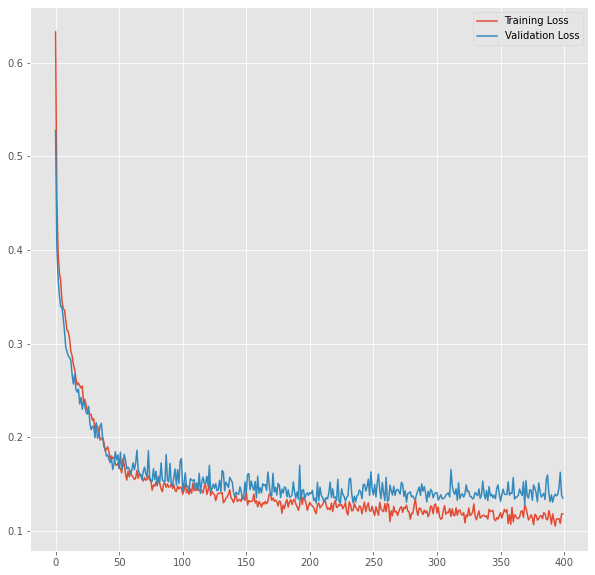

In [53]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

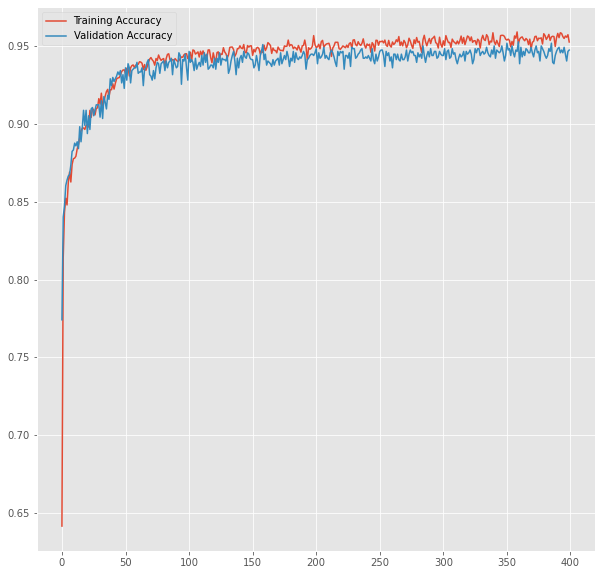

In [54]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [55]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9524489795918362
Validation Accuracy: 0.9472759226713533


In [56]:
np.argmax(valid_acc)

359

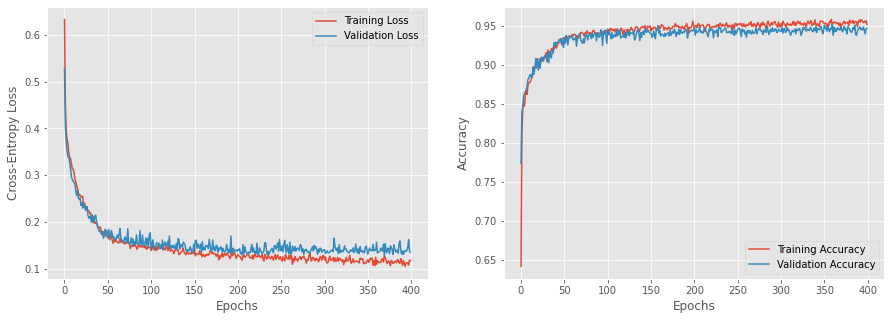

In [57]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [59]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [60]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [61]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [62]:
def evaluate(model_gcn, graph, features, labels, mask):
    model_gcn.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [63]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model_gcn.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.7032, validation loss: 0.7025, training accuracy: 0.5037, validation accuracy: 0.5713, Time: 0.5093
Epoch: 10, train loss: 0.6819, validation loss: 0.6811, training accuracy: 0.5686, validation accuracy: 0.5713, Time: 0.6962
Epoch: 20, train loss: 0.6634, validation loss: 0.6633, training accuracy: 0.5686, validation accuracy: 0.5713, Time: 0.5963
Epoch: 30, train loss: 0.6454, validation loss: 0.6459, training accuracy: 0.5686, validation accuracy: 0.6990, Time: 0.5549
Epoch: 40, train loss: 0.6281, validation loss: 0.6293, training accuracy: 0.7696, validation accuracy: 0.7600, Time: 0.4985
Epoch: 50, train loss: 0.6117, validation loss: 0.6135, training accuracy: 0.7589, validation accuracy: 0.7616, Time: 0.4628
Epoch: 60, train loss: 0.5961, validation loss: 0.5981, training accuracy: 0.7651, validation accuracy: 0.7628, Time: 0.4339
Epoch: 70, train loss: 0.5819, validation loss: 0.5843, training accuracy: 0.7640, validation accuracy: 0.7595, Time: 0.4118
E

Epoch: 660, train loss: 0.4872, validation loss: 0.4947, training accuracy: 0.7685, validation accuracy: 0.7621, Time: 0.3679
Epoch: 670, train loss: 0.4871, validation loss: 0.4945, training accuracy: 0.7696, validation accuracy: 0.7619, Time: 0.3687
Epoch: 680, train loss: 0.4873, validation loss: 0.4940, training accuracy: 0.7685, validation accuracy: 0.7619, Time: 0.3688
Epoch: 690, train loss: 0.4870, validation loss: 0.4953, training accuracy: 0.7696, validation accuracy: 0.7633, Time: 0.3678
Epoch: 700, train loss: 0.4867, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7621, Time: 0.3677
Epoch: 710, train loss: 0.4866, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7619, Time: 0.3678
Epoch: 720, train loss: 0.4865, validation loss: 0.4944, training accuracy: 0.7691, validation accuracy: 0.7631, Time: 0.3676
Epoch: 730, train loss: 0.4865, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7631, Time:

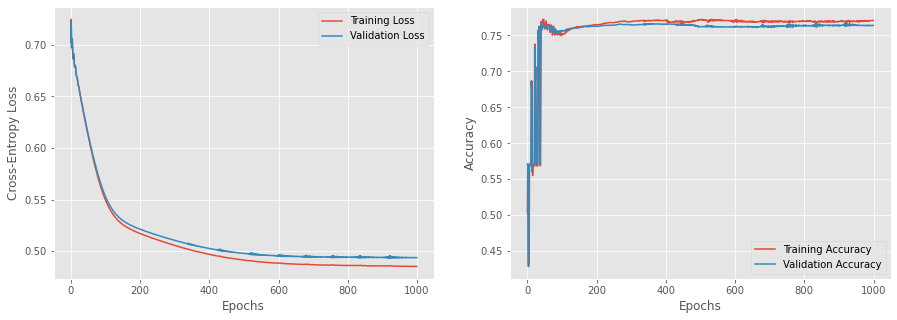

In [64]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.76377394183022
-------------------------------------------------------------
Classification Accuracy training set 0.7707509881422925
-------------------------------------------------------------
Confusion Matrix validation set:
[[1853  563]
 [ 436 1377]]
-------------------------------------------------------------
Confusion Matrix training set:
[[787 220]
 [186 578]]


In [66]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(in=24, out=2, normalization=both, activation=None)
)>

## Generate Test Graph

Based on the test data, a new test graph is generated. This is the same procedure as is done in the the data script. It is repeated here for the test graph so that every A-Z simulation contains a new test graph. This ensures, that there is not some graph sampling bias. Note, different training graphs were tested as well. The results are consistent regardless of the generated graph.

In [67]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [ ]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [ ]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [ ]:
A = A + A.T

In [ ]:
G_test = nx.from_numpy_matrix(A)

In [ ]:
test_features = pd.Series(TEST.satisfaction)

## Assign the data to a dgl graph

In [ ]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [ ]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define the inference function to get the test graph results

In [ ]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Get the test graph results

In [ ]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

In [ ]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

In [ ]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

In [ ]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

In [ ]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

In [ ]:
model.layers

## ANN Simulations

The following code was used to simulated the consistency of ANN results. This was done to compare the ANN results with the GNN results.

In [ ]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

In [ ]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

In [ ]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ANN Results

Belwo the results for the ANN are generated.

In [ ]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

In [ ]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

In [ ]:
results[0]

## Below the results for the Support Vector Machine are Generated

The label is transformed such that unsatisfied or neutral passengers are coded as -1 and satisfied passenger are coded as 1. 

In [ ]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

### Get results for the Test data

In [ ]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [ ]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

## Results for the Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

In [ ]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

## Results for AdaBoost

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

## Results for Naive Bayes

In [ ]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

## Results for QDA

In [ ]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

## Results for Logistic Regression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))